# This is the notebook for project Contextual Privacy Policy for Mobile Apps. Ultimately, we aim to achieve the privacy-related icons detection and classification.

## We first to adapt an existing icons classifier.

In [ ]:
import torch
import numpy as np
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)

cuda:0


In [ ]:
# check CPU
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.176
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

In [ ]:
!nvidia-smi

Thu Apr 20 13:15:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    32W /  70W |  10481MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# A simpler model

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
      
    self.conv1 = nn.Conv2d(1, 10, kernel_size=3) #input:32*32 output:30*30

    # maxpooling: filter:2 stride:2 output:15*15

    #self.conv2 = nn.Conv2d(10, 20, kernel_size=4) #input:15*15 output:12*12

    # maxpooling: filter:2 stride:2 output:6*6
    
    # 15*15*10=2250
    self.fc1 = nn.Linear(2250, 50)
    self.fc2 = nn.Linear(50, 9)

  def forward(self, x):

    x = self.conv1(x)
    x = F.elu(x) 
        
    x = F.max_pool2d(input=x, kernel_size=2, stride=2)
        
    # x = self.conv2(x)

    x = F.dropout(x, p=0.1, training=self.training)

    # x = F.elu(x)

    # x = F.max_pool2d(input=x, kernel_size=2, stride=2)

    x = x.view(x.size(0),-1)
        
    x = self.fc1(x)
    x = F.elu(x)
        
    x = self.fc2(x)
    x = F.softmax(x)

    return x


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Semantic_Model(nn.Module):
    def __init__(self, embedding_size, num_classes, model_type='', siamese=False, conv_only=False):
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 384, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(384, 384, kernel_size=1, padding=1)
        self.conv3 = nn.Conv2d(384, 384, kernel_size=2, padding=1)
        self.conv4 = nn.Conv2d(384, 640, kernel_size=2, padding=1)
        self.conv5 = nn.Conv2d(640, 640, kernel_size=2, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.1)
        
        self.conv6 = nn.Conv2d(640, 640, kernel_size=1, padding=1)
        self.conv7 = nn.Conv2d(640, 768, kernel_size=2, padding=1)
        self.conv8 = nn.Conv2d(768, 768, kernel_size=2, padding=1)
        self.conv9 = nn.Conv2d(768, 768, kernel_size=2, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.2)
        
        self.conv10 = nn.Conv2d(768, 768, kernel_size=1, padding=1)
        self.conv11 = nn.Conv2d(768, 896, kernel_size=2, padding=1)
        self.conv12 = nn.Conv2d(896, 896, kernel_size=2, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.3)
        
        self.conv13 = nn.Conv2d(896, 896, kernel_size=3, padding=1)
        self.conv14 = nn.Conv2d(896, 1024, kernel_size=2, padding=1)
        self.conv15 = nn.Conv2d(1024, 1024, kernel_size=2, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(0.4)
        
        self.conv16 = nn.Conv2d(1024, 1024, kernel_size=1, padding=1)
        self.conv17 = nn.Conv2d(1024, 1152, kernel_size=2, padding=1)
        self.dropout5 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(1152*6*6, 1152)
        self.fc2 = nn.Linear(1152, embedding_size)
        self.fc3 = nn.Linear(embedding_size, num_classes)
        
    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = self.pool1(x)
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = F.elu(self.conv5(x))
        x = self.pool2(x)
        x = self.dropout1(x)
        x = F.elu(self.conv6(x))
        x = F.elu(self.conv7(x))
        x = F.elu(self.conv8(x))
        x = F.elu(self.conv9(x))
        x = self.pool3(x)
        x = self.dropout2(x)
        
        x = F.elu(self.conv10(x))
        x = F.elu(self.conv11(x))
        x = F.elu(self.conv12(x))
        x = self.pool4(x)
        x = self.dropout3(x)
        
        x = F.elu(self.conv13(x))
        x = F.elu(self.conv14(x))
        x = F.elu(self.conv15(x))
        x = self.pool5(x)
        x = self.dropout4(x)
        
        x = F.elu(self.conv16(x))
        #x = F.elu(self.conv16_1(x))
        x = F.elu(self.conv17(x))
        x = self.dropout5(x)
        x = torch.flatten(x, 1) 
#         x = torch.permute(x, (0, 2, 3, 1))
#         flatten = nn.Flatten(1, 2)
#         x = flatten(x)
#         print(x.shape)
    
    
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        print(x.shape)
        
        return x

In [ ]:
# This is the network we implemented based on the original paper.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=384, kernel_size=3, padding=1) # input:32*32
        
        # maxpooling: filter:2 stride:2 output:16*16
        
        self.conv2 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=1) # input:16*16 output:16*16
        self.conv3 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=2, padding=1) # input:16*16 output:17*17 (SAME padding:padding:top=0,bottom=1,left=0,right=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=640, kernel_size=2, padding=1) #input:17*17 output:18*18
        self.conv5 = nn.Conv2d(in_channels=640, out_channels=640, kernel_size=2) # input:18*18 output:17*17
        
        # maxpooling: filter:2 stride:2 output:8*8
        
        self.conv6 = nn.Conv2d(in_channels=640, out_channels=640, kernel_size=1) # input:8*8 output:8*8
        self.conv7 = nn.Conv2d(in_channels=640, out_channels=768, kernel_size=2, padding=1) # input:8*8 output:9*9
        self.conv8 = nn.Conv2d(in_channels=768, out_channels=768, kernel_size=2, padding=1) # input:9*9 output:10*10
        self.conv9 = nn.Conv2d(in_channels=768, out_channels=768, kernel_size=2) # input:10*10 output:9*9
        
        # maxpooling: filter:2 stride:2 output:4*4
        
        self.conv10 = nn.Conv2d(in_channels=768, out_channels=768, kernel_size=1) # input:4*4 output:4*4
        self.conv11 = nn.Conv2d(in_channels=768, out_channels=896, kernel_size=2, padding=1) # input:4*4 output:5*5
        self.conv12 = nn.Conv2d(in_channels=896, out_channels=896, kernel_size=2) # input:5*5 output:4*4
        
        # maxpooling: filter:2 stride:2 output:2*2
        
        self.conv13 = nn.Conv2d(in_channels=896, out_channels=896, kernel_size=3, padding=1) # input:2*2 output:2*2
        self.conv14 = nn.Conv2d(in_channels=896, out_channels=1024, kernel_size=2, padding=1) # input:2*2 output:3*3
        self.conv15 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=2) # input:3*3 output:2*2
        
        # maxpooling: filter:2 stride:2 output:1*1
        
        self.conv16 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=2, padding=1) # input:1*1 output:2*2
        self.conv17 = nn.Conv2d(in_channels=1024, out_channels=1152, kernel_size=2) # input:2*2 output:1*1
        
        self.fc1 = nn.Linear(in_features=1152, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=99)

    def forward(self, x):
        
        x = self.conv1(x)
        x = F.elu(x) 
        
        x = F.max_pool2d(input=x, kernel_size=2, stride=2) # batch*384*16*16
        
        x = self.conv2(x)
        x = F.elu(x) 
        
        x = self.conv3(x)
        x = F.elu(x) 
        
        x = self.conv4(x)
        x = F.elu(x) 
        
        x = self.conv5(x)
        x = F.elu(x) 
        
        x = F.max_pool2d(input=x, kernel_size=2, stride=2)
        
        x = F.dropout(x, p=0.1, training=self.training) 
        
        x = self.conv6(x)
        x = F.elu(x) 
        
        x = self.conv7(x)
        x = F.elu(x) 
        
        x = self.conv8(x)
        x = F.elu(x)
        
        x = self.conv9(x)
        x = F.elu(x)
        
        x = F.max_pool2d(input=x, kernel_size=2, stride=2)
        
        x = F.dropout(x, p=0.2, training=self.training)
        
        x = self.conv10(x)
        x = F.elu(x)
        
        x = self.conv11(x)
        x = F.elu(x)
        
        x = self.conv12(x)
        x = F.elu(x)
        
        x = F.max_pool2d(input=x, kernel_size=2, stride=2)
        
        x = F.dropout(x, p=0.3, training=self.training)
        
        x = self.conv13(x)
        x = F.elu(x)
        
        x = self.conv14(x)
        x = F.elu(x)
        
        x = self.conv15(x)
        x = F.elu(x)
        
        x = F.max_pool2d(input=x, kernel_size=2, stride=2)
        
        x = F.dropout(x, p=0.4, training=self.training)
        
        x = self.conv16(x)
        x = F.elu(x)
        
        x = self.conv17(x)
        x = F.elu(x)
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = x.view(x.size(0),-1)
        
        x = self.fc1(x)
        x = F.elu(x)
        
        x = self.fc2(x)
        # x = F.softmax(x)
        
        return x


In [ ]:
# load the data
x_train = np.load("/content/gdrive/MyDrive/mobile-semantics-classification/training_x.npy")
y_train = np.load("/content/gdrive/MyDrive/mobile-semantics-classification/training_y.npy")
x_test = np.load("/content/gdrive/MyDrive/mobile-semantics-classification/validation_x.npy")
y_test = np.load("/content/gdrive/MyDrive/mobile-semantics-classification/validation_y.npy")

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# num_classes = np.unique(y_train).shape[0]
# Print Unique Icon Classes, 99 classes
# print(np.unique(y_train))
# print(num_classes, ' classes')

# Convert class vectors to binary class matrices.
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

#print(y_train[0])
# y_train = torch.tensor(y_train)
# y_train = F.one_hot(y_train.to(torch.int64), num_classes=num_classes)
# y_train = np.array(y_train)
#print(y_train[0])

# idx_train = np.where((y_train == [72]) | (y_train == [42]) 
#  | (y_train == [91]) | (y_train == [6]) | (y_train == [40])
#   | (y_train == [43]) | (y_train == [82]) | (y_train == [3]) | (y_train == [68])
#    )

# x_train = x_train[idx_train[0]]
# y_train = y_train[idx_train[0]]

# print(np.where(y_train == [6]))

# change the selected labels to 0-11
# y_train[np.where(y_train==[3])] = [7]
# y_train[np.where(y_train==[72])] = [0]
# y_train[np.where(y_train==[42])] = [1]

# y_train[np.where(y_train==[91])] = [2]
# y_train[np.where(y_train==[6])] = [3]

# y_train[np.where(y_train==[40])] = [4]
# y_train[np.where(y_train==[43])] = [5]
# y_train[np.where(y_train==[82])] = [6]
# y_train[np.where(y_train==[68])] = [8]


# print("idx_train length: ", idx_train[0].shape)
# print('x_train_selected shape:', x_train.shape)
# print('y_train_selected shape:', y_train.shape)



# idx_test = np.where((y_test == [72]) | (y_test == [42]) 
#  | (y_test == [91]) | (y_test == [6]) | (y_test == [40])
#   | (y_test == [43]) | (y_test == [82]) | (y_test == [3]) | (y_test == [68])
#    )

# x_test = x_test[idx_test[0]]
# y_test = y_test[idx_test[0]]

# change the selected labels to 0-11
# y_test[np.where(y_test==[3])] = [7]
# y_test[np.where(y_test==[72])] = [0]
# y_test[np.where(y_test==[42])] = [1]

# y_test[np.where(y_test==[91])] = [2]
# y_test[np.where(y_test==[6])] = [3]

# y_test[np.where(y_test==[40])] = [4]
# y_test[np.where(y_test==[43])] = [5]
# y_test[np.where(y_test==[82])] = [6]
# y_test[np.where(y_test==[68])] = [8]


# print("idx_test length: ", idx_test[0].shape)
# print('x_test_selected shape:', x_test.shape)
# print('y_test_selected shape:', y_test.shape)

print("reshape: ")
x_train = x_train.reshape([x_train.shape[0], x_train.shape[3], x_train.shape[1], x_train.shape[2]])
x_test = x_test.reshape([x_test.shape[0], x_test.shape[3], x_test.shape[1], x_test.shape[2]])

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

num_classes = np.unique(y_train).shape[0]
print(num_classes, ' classes')
# print(np.unique(y_train))

# num_classes = np.unique(y_test).shape[0]
# print(num_classes, ' classes')
# print(np.unique(y_test))

x_train shape: (113854, 32, 32, 1)
y_train shape: (113854, 1)
x_test shape: (4809, 32, 32, 1)
y_test shape: (4809, 1)
113854 train samples
4809 test samples
reshape: 
x_train shape: (113854, 1, 32, 32)
y_train shape: (113854, 1)
x_test shape: (4809, 1, 32, 32)
y_test shape: (4809, 1)
99  classes


In [ ]:
# use dataloader

# print(x_train[0])
# print(x_train.mean())

mean = x_train.mean()
std = x_train.std()

# mean = mean/len(x_train)
# std = std/len(x_train)

print("mean: ", mean)
print("std: ", std)

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std), # featurewise centering

    # data augmentation
    # transforms.RandomAffine(degrees=0, translate=(0.1,0.1)), # randomly moved along the x- and y-axis by up to 10%

    # add more operations
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(15)
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std), # featurewise centering
])

class CustomDataset(Dataset):
    
    def __init__(self, images, labels, transform=None):
        self.labels = labels
        self.images = images
        
        self.labels = torch.LongTensor(labels)
        
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]
        
        if self.transform is not None:

            image = self.transform(image)
            image = image.permute(1,0,2)

        
        return image, label
    
batch_size = 16
    
train_loader = DataLoader(CustomDataset(x_train[:113840],y_train[:113840],transform_train), batch_size=batch_size, shuffle=True)
# validation_loader = DataLoader(CustomDataset(x_train[9600:11200],y_train[9600:11200]), batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(CustomDataset(x_test[:1600],y_test[:1600]), batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(CustomDataset(x_test[0:4800],y_test[0:4800],transform_val), batch_size=batch_size, shuffle=True)

mean:  0.5331238
std:  0.33663777


In [ ]:
# choose model

# -------------- use our own model -------------
model = Net().to(device)

# --------------- use resnet18 -------------------

# from torchvision import models

# model = models.resnet18().to(device)
# in_feature_num = model.fc.in_features
# model.fc = nn.Linear(in_feature_num, 99)
# # model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), padding=(3,3), stride=(2,2), bias=False)
# model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(5,5), padding=(3,3), stride=(2,2), bias=False)

# --------------- use resnet50 -------------------

# from torchvision import models

# model = models.resnet50().to(device)
# in_feature_num = model.fc.in_features
# model.fc = nn.Linear(in_feature_num, 99)
# # model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), padding=(3,3), stride=(2,2), bias=False)
# model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(5,5), padding=(3,3), stride=(2,2), bias=False)

# --------------- end ----------------------------

model = model.to(device)

In [ ]:
# train the model

# Put all hyperparameters together 
initial_leanring_rate = 0.001
learning_rate_weight_decay = 3e-4
epoch_num = 5



loss = nn.CrossEntropyLoss()

optimizer = torch.optim.RMSprop(params=model.parameters(), lr=initial_leanring_rate, weight_decay=learning_rate_weight_decay)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=initial_leanring_rate, weight_decay=learning_rate_weight_decay)

best_model = model

best_accuracy = 0

best_epoch = 0

train_accuracy_all = []

validation_accuracy_all = []

class_correct = list(0. for i in range(num_classes))

class_total = list(0. for i in range(num_classes))

for epoch in range(epoch_num):
    
    start_time = time.time()
    
    train_accuracy = 0
    validation_accuracy = 0
    train_loss = 0
    validation_loss = 0

    model.train()
    for i, data in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        train_output = model(data[0].to(device))
        
        data[1] = data[1].view(data[1].shape[0])

        batch_loss = loss(train_output, data[1].to(device))
        # print(train_output.size())
        # print(data[1].size())
        batch_loss.backward()
        optimizer.step()
        
        train_accuracy = train_accuracy + np.sum(np.argmax(train_output.cpu().data.numpy(),axis=1) == data[1].cpu().numpy())
        # print('correct train in this batch: ', np.sum(np.argmax(train_output.cpu().data.numpy(),axis=1) == data[1].cpu().numpy()))
        # print('all correct train: ', train_accuracy)
        train_loss = train_loss + batch_loss.item()
        
        # print("training | num of right labelling in this batch: ", np.sum(np.argmax(train_output.data.numpy(),axis=1) == data[1].numpy()))
        
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(validation_loader):
            
            validation_output = model(data[0].to(device))
            
            data[1] = data[1].view(data[1].shape[0])
            
            batch_loss = loss(validation_output, data[1].to(device))
            
            validation_accuracy = validation_accuracy + np.sum(np.argmax(validation_output.cpu().data.numpy(),axis=1) == data[1].cpu().numpy())
            # print('correct val in this batch: ', np.sum(np.argmax(validation_output.cpu().data.numpy(),axis=1) == data[1].cpu().numpy()))
            # print('all correct val: ', validation_accuracy)
            validation_loss = validation_loss + batch_loss.item()
            
            # print("validation | num of right labelling: ", np.sum(np.argmax(validation_output.data.numpy(),axis=1) == data[1].numpy()))

            c = (np.argmax(validation_output.cpu().data.numpy(),axis=1) == data[1].cpu().numpy())
            c = c.squeeze()
            for i in range(batch_size):
              i_label = data[1][i]
              class_correct[i_label] += c[i]
              class_total[i_label] += 1
            
        print("epoch: ", epoch + 1)
        print("train accuracy: ", train_accuracy/(train_loader.__len__()*batch_size))
        print("train loss: ", train_loss/(train_loader.__len__()*batch_size))
        print("validation accuracy: ", validation_accuracy/(validation_loader.__len__()*batch_size))
        print("validation loss: ", validation_loss/(validation_loader.__len__()*batch_size))
        
        print("time cost: %2.2f s" % (time.time() - start_time))

        num_90_percent_correct = 0
        num_80_percent_correct = 0
        num_70_percent_correct = 0
        num_60_percent_correct = 0
        num_50_percent_correct = 0
        num_under_50_percent_correct = 0

        for i in range(0, num_classes):

          class_percent_correct = np.round(100 * class_correct[i] / class_total[i], 2)

          print(f"The accuracy of class {i}: {class_percent_correct}%")

          if class_percent_correct >= 90:
            num_90_percent_correct = num_90_percent_correct + 1
          elif class_percent_correct >= 80:
            num_80_percent_correct = num_80_percent_correct + 1
          elif class_percent_correct >= 70:
            num_70_percent_correct = num_70_percent_correct + 1
          elif class_percent_correct >= 60:
            num_60_percent_correct = num_60_percent_correct + 1
          elif class_percent_correct >= 50:
            num_50_percent_correct = num_50_percent_correct + 1
          else:
            num_under_50_percent_correct = num_under_50_percent_correct + 1
        
        print("The number of classes with accuracy equal to or more than 90%: ", num_90_percent_correct)
        print("The number of classes with accuracy equal to or more than 80%: ", num_80_percent_correct)
        print("The number of classes with accuracy equal to or more than 70%: ", num_70_percent_correct)
        print("The number of classes with accuracy equal to or more than 60%: ", num_60_percent_correct)
        print("The number of classes with accuracy equal to or more than 50%: ", num_50_percent_correct)
        print("The number of classes with accuracy lower than 50%: ", num_under_50_percent_correct)

        train_accuracy_all.append(train_accuracy/(train_loader.__len__()*batch_size))
        validation_accuracy_all.append(validation_accuracy/(validation_loader.__len__()*batch_size))

        
        
#         print("epoch training | num of right labelling: ", train_accuracy)
#         print("epoch training | len of train_loader: ", train_loader.__len__()*batch_size)
#         print("epoch val | num of right labelling: ", validation_accuracy)
#         print("epoch val | len of validation_loader: ", validation_loader.__len__()*batch_size)
        
        if best_accuracy < (validation_accuracy/validation_loader.__len__()):
            best_model = model
            best_accuracy = validation_accuracy/validation_loader.__len__()
            best_epoch = epoch + 1
            
        

epoch:  1
train accuracy:  0.027108222066057626
train loss:  20783411342.524437
validation accuracy:  0.13020833333333334
validation loss:  0.33371242130796114
time cost: 1072.65 s
The accuracy of class 0: 0.0%
The accuracy of class 1: 0.0%
The accuracy of class 2: 0.0%
The accuracy of class 3: 0.0%
The accuracy of class 4: 0.0%
The accuracy of class 5: 0.0%
The accuracy of class 6: 0.0%
The accuracy of class 7: 0.0%
The accuracy of class 8: 0.0%
The accuracy of class 9: 0.0%
The accuracy of class 10: 0.0%
The accuracy of class 11: 0.0%
The accuracy of class 12: 0.0%
The accuracy of class 13: 0.0%
The accuracy of class 14: 0.0%
The accuracy of class 15: 0.0%
The accuracy of class 16: 0.0%
The accuracy of class 17: 0.0%
The accuracy of class 18: 100.0%
The accuracy of class 19: 0.0%
The accuracy of class 20: 0.0%
The accuracy of class 21: 0.0%
The accuracy of class 22: 0.0%
The accuracy of class 23: 0.0%
The accuracy of class 24: 0.0%
The accuracy of class 25: 0.0%
The accuracy of class

KeyboardInterrupt: ignored

[0.45231026001405483, 0.8082308503162333, 0.8679023190442726, 0.889414968376669, 0.9023453970484892, 0.9090653548840478, 0.914827828531272, 0.9187456078706957, 0.9224701335207308, 0.9251669009135629, 0.9266514406184118, 0.9278021784961349, 0.9294799718903725, 0.9311138439915672, 0.931693605059733, 0.9329936753338018, 0.9344430780042164, 0.9352248770203795, 0.9354093464511595, 0.9354181307097681]
[0.80125, 0.8466666666666667, 0.8560416666666667, 0.8466666666666667, 0.875625, 0.8710416666666667, 0.8675, 0.8758333333333334, 0.8835416666666667, 0.8777083333333333, 0.8664583333333333, 0.86875, 0.8833333333333333, 0.8879166666666667, 0.8858333333333334, 0.8841666666666667, 0.8839583333333333, 0.889375, 0.8864583333333333, 0.8916666666666667]


ValueError: ignored

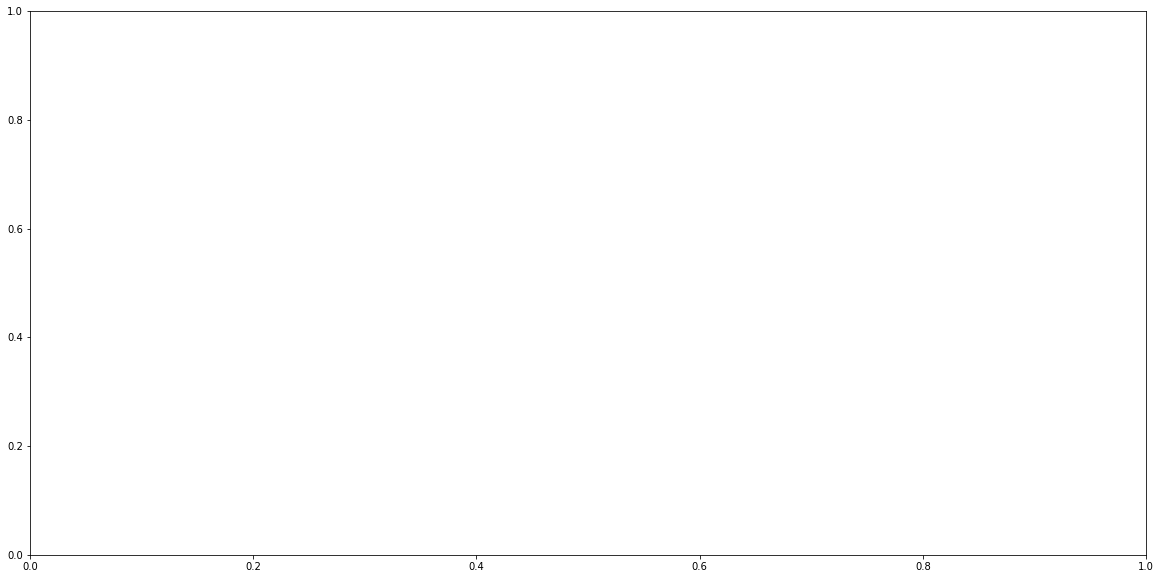

In [ ]:
# visualization

print(train_accuracy_all)
print(validation_accuracy_all)

fig = plt.figure(figsize=(20,10))

# ax1=fig.add_subplot(121)
# ax1.plot(np.arange(1,11),train_accuracy_all)

# ax2=fig.add_subplot(222)
# ax2.plot(np.arange(1,11),validation_accuracy_all)

plt.plot(np.arange(1,epoch_num+1),train_accuracy_all,'r',label='train accuracy')
plt.plot(np.arange(1,epoch_num+1),validation_accuracy_all,'y',label='validation accuracy')
plt.ylim(0.0, 1.0)
plt.xticks(np.arange(1,epoch_num+1))
plt.title('The train accuracy and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [ ]:
# save the model

# PATH = './saved_model/model-10000-10-resnet18.pkl'
# torch.save(best_model, PATH)

# trained_model = torch.load(PATH)

# save the parameters

# PATH = '/content/gdrive/MyDrive/mobile-semantics-classification/saved_model/model-10000-10-resnet18.pkl'
# torch.save(best_model.state_dict(), PATH)

PATH = '/content/gdrive/MyDrive/mobile-semantics-classification/saved_model/model-99-semantic.pkl'
torch.save(best_model.state_dict(), PATH)
print("Accuracy for best model: ", best_accuracy/batch_size)
print("Epoch: ", best_epoch)

# trained_model = model()
# trained_model.load_state_dict(torch.load(PATH))

Accuracy for best model:  0.13020833333333334
Epoch:  1


In [ ]:
# PATH = '/content/gdrive/MyDrive/mobile-semantics-classification/saved_model/model-99-resnet18.pkl'
# trained_model = model()
# trained_model.load_state_dict(torch.load(PATH))

from torchvision import models

model = models.resnet18()
in_feature_num = model.fc.in_features
model.fc = nn.Linear(in_feature_num, 99)
# model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), padding=(3,3), stride=(2,2), bias=False)
model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(5, 5), padding=(3, 3), stride=(2, 2),
                            bias=False)
# PATH = "C:/ANU/2022 s2/honours project/code/UIED-master/model/model-99-resnet18.pkl"
PATH = '/content/gdrive/MyDrive/mobile-semantics-classification/saved_model/model-99-resnet18.pkl'
# trained_model = model()
model.load_state_dict(torch.load(PATH))

model = model.to(device)

model.eval()

validation_accuracy = 0
validation_loss = 0

class_correct = list(0. for i in range(num_classes))

class_total = list(0. for i in range(num_classes))

loss = nn.CrossEntropyLoss()

with torch.no_grad():
    for i, data in enumerate(validation_loader):
            
      validation_output = model(data[0].to(device))
            
      data[1] = data[1].view(data[1].shape[0])
            
      batch_loss = loss(validation_output, data[1].to(device))
            
      validation_accuracy = validation_accuracy + np.sum(np.argmax(validation_output.cpu().data.numpy(),axis=1) == data[1].cpu().numpy())

      if i == 0:
        print("validation_output for i = 0: ", validation_output.cpu().data.numpy())
        # print("index 47's' value in output: ", validation_output.cpu().data.numpy()[0][47])
        print("max value of output for i = 0: ", np.max(validation_output.cpu().data.numpy(),axis=1))
        print("label for i == 0: ", np.argmax(validation_output.cpu().data.numpy(),axis=1))
        print("ground truth label: ", data[1].cpu().numpy())

      # print('correct val in this batch: ', np.sum(np.argmax(validation_output.cpu().data.numpy(),axis=1) == data[1].cpu().numpy()))
      # print('all correct val: ', validation_accuracy)
      validation_loss = validation_loss + batch_loss.item()
            
      # print("validation | num of right labelling: ", np.sum(np.argmax(validation_output.data.numpy(),axis=1) == data[1].numpy()))

      c = (np.argmax(validation_output.cpu().data.numpy(),axis=1) == data[1].cpu().numpy())
      c = c.squeeze()
      for i in range(batch_size):
        i_label = data[1][i]
        class_correct[i_label] += c[i]
        class_total[i_label] += 1

print("validation accuracy: ", validation_accuracy/(validation_loader.__len__()*batch_size))
print("validation loss: ", validation_loss/(validation_loader.__len__()*batch_size))

for i, data in enumerate(validation_loader):
  if i == 0:
    print(data[0][0])
    break

validation_output for i = 0:  [[-25.882294 -20.320332 -25.39412  ... -23.935753 -20.553226 -28.570993]
 [-23.59986  -21.339466 -26.223984 ... -24.797201 -25.568342 -23.635752]
 [-21.351458 -21.120495 -21.546206 ... -24.807516 -18.725021 -22.78024 ]
 ...
 [-26.740221 -23.011673 -21.927551 ... -24.763994 -23.988007 -21.470495]
 [-21.624517 -19.74502  -22.974176 ... -23.65514  -21.117243 -24.760237]
 [-21.08245  -20.526806 -15.569989 ... -25.367752 -21.471827 -19.67049 ]]
max value of output for i = 0:  [ -7.497398   -5.878445  -13.327341   -6.38219    -6.162014   -7.850758
  -8.273866   -8.013928   -8.041926  -12.184144  -11.309552   -7.51927
  -5.9554377  -6.1306343  -7.103428   -7.952137 ]
label for i == 0:  [47 18 62  7 21 18 23  7 18 26 82 51 23 26 17 86]
ground truth label:  [47 18 31  7 21 18 23  7 18 93 42 51 23 26 17 86]
validation accuracy:  0.8910416666666666
validation loss:  0.034640514336521544
tensor([[[0.0705, 0.0705, 0.0705,  ..., 0.0705, 0.0705, 0.0705],
         [0.0705

array mean:  -1.5646219e-07
array std:  1.0
array_tensor:  tensor([[[[-1.1144, -1.1144, -1.1144,  ...,  0.9135, -0.6074, -1.1144],
          [-1.0941, -1.1144, -1.1144,  ...,  0.2241, -1.1346, -1.0738],
          [-1.1144, -1.0941, -1.0941,  ..., -0.6682, -1.1955, -1.0941],
          ...,
          [-1.1144, -1.0941, -1.0738,  ..., -1.0738, -1.1144, -1.1144],
          [-1.1346, -1.1144, -1.1144,  ..., -1.1144, -1.1144, -1.1144],
          [-1.1144, -1.1144, -1.1144,  ..., -1.1144, -1.1144, -1.1144]]]])
output:  tensor([[-22.4157, -15.9926, -19.4934, -16.0830, -27.3012, -25.5356, -19.0801,
         -19.2457, -23.5549, -24.8292, -21.9697, -16.6216, -26.7797, -23.8141,
         -17.4010, -22.3208, -20.5218, -17.8018, -21.0433, -27.5869, -24.3158,
         -22.1225, -24.7412, -20.0983, -22.5773, -17.0228, -18.9030, -20.3259,
         -21.2309, -22.7446, -22.1759, -26.4450, -16.5851, -21.2550, -23.8639,
         -22.7432, -23.6646, -17.8994, -24.4697, -21.1405, -23.9674, -21.2442,
        

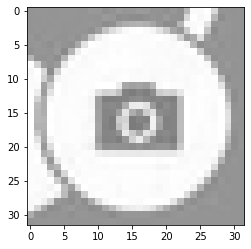

In [ ]:
# convert .npy file to image

import PIL
from PIL import Image
import matplotlib.pyplot as plt

sample_data = np.load('/content/gdrive/MyDrive/mobile-semantics-classification/validation_x.npy')
# print(sample_data[0,:,:,:].shape)
array = np.reshape(sample_data[10,:,:,:], [32, 32])

# array = np.array([array[1], array[0]])

sample_image = Image.fromarray(array)
# sample_image.show()
plt.imshow(sample_image)
# print("the array of image: ", np.asarray(sample_image))

array = np.asarray(sample_image)
array = array.astype('float32')
array = array / 255
array = (array - array.mean()) / array.std()

print("array mean: ", array.mean())
print("array std: ", array.std())

array = array.reshape(1, 1, 32, 32)

array = torch.tensor(array)
array = array.permute(0,1,3,2)
print("array_tensor: ", array)

array_pred_label = model(array.to(device))
print("output: ", array_pred_label)
print("max value in output: ", np.max(array_pred_label.cpu().data.numpy()))
print("index of max value in output: ", np.argmax(array_pred_label.cpu().data.numpy(),axis=1))

The tensorof image:  tensor([[[0.0705, 0.0705, 0.0705,  ..., 0.0705, 0.0705, 0.0705],
         [0.0705, 0.0705, 0.0705,  ..., 0.0705, 0.0705, 0.0705],
         [0.0705, 0.0705, 0.0705,  ..., 0.0705, 0.0705, 0.0705],
         ...,
         [0.0705, 0.0705, 0.0705,  ..., 0.0705, 0.0705, 0.0705],
         [0.0705, 0.0705, 0.0705,  ..., 0.0705, 0.0705, 0.0705],
         [0.0705, 0.0705, 0.0705,  ..., 0.0705, 0.0705, 0.0705]]])
output:  [-25.882294 -20.320332 -25.39412  -18.534277 -28.546036 -26.31986
 -27.668192 -20.870684 -26.88417  -25.343872 -23.855581 -27.971272
 -24.57711  -26.998487 -27.562416 -23.367775 -25.057673 -22.766819
 -21.701681 -22.935308 -24.24815  -20.734245 -22.174034 -27.750294
 -22.207317 -24.506102 -22.288458 -24.649044 -22.191935 -17.628578
 -27.971813 -24.329483 -23.312494 -16.041475 -27.03294  -24.496479
 -30.442802 -24.313707 -27.013783 -24.724014 -25.665901 -23.28429
 -23.6993   -24.86848  -20.025352 -25.028997 -24.247683  -7.497398
 -24.714329 -24.536636 -22.376

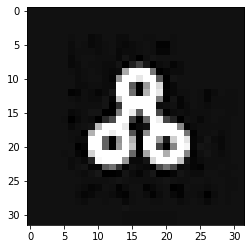

In [ ]:
for i, data in enumerate(validation_loader):
  if i == 0:
    # print("The first image of validation set: ", data[0][0])
    first_image = np.reshape(data[0][0], [32, 32])
    sample_first_image = Image.fromarray(np.array(first_image*255))

    plt.imshow(sample_first_image)
    # print("The array of image: ", np.asarray(sample_first_image))
    # print("The array of image: ", first_image)

    print("The tensorof image: ", data[0][0])

    first_image_output = model(data[0].to(device))
    print("output: ", (first_image_output.cpu().data.numpy())[0])

    print("max value in output: ", np.max(first_image_output.cpu().data.numpy()[0]))
    print("index of max value in output: ", np.argmax(first_image_output.cpu().data.numpy()[0]))

    break


In [ ]:
# check if the dataset itself is random (e.g. no order for labels)

from collections import Counter

y_train_list = y_train[0:9600].flatten().tolist()
y_train_set = set(y_train_list)
print("The number of different labels in the first 9600 training set: ", len(y_train_set))

result = Counter(y_train_list)
print(result)

The number of different labels in the first 9600 training set:  99
Counter({18.0: 507, 26.0: 321, 17.0: 287, 94.0: 224, 7.0: 208, 1.0: 133, 47.0: 118, 14.0: 107, 37.0: 104, 54.0: 103, 68.0: 101, 44.0: 101, 13.0: 100, 87.0: 100, 9.0: 100, 6.0: 98, 72.0: 96, 93.0: 95, 49.0: 95, 41.0: 94, 60.0: 94, 58.0: 94, 46.0: 94, 86.0: 94, 65.0: 93, 83.0: 93, 88.0: 92, 53.0: 92, 40.0: 92, 24.0: 92, 23.0: 91, 90.0: 91, 25.0: 90, 55.0: 90, 92.0: 89, 34.0: 89, 12.0: 89, 76.0: 89, 20.0: 89, 61.0: 88, 28.0: 88, 43.0: 87, 8.0: 87, 80.0: 87, 11.0: 87, 79.0: 87, 10.0: 87, 82.0: 86, 91.0: 86, 84.0: 86, 0.0: 85, 77.0: 85, 21.0: 85, 95.0: 85, 48.0: 84, 62.0: 84, 78.0: 83, 67.0: 83, 2.0: 83, 59.0: 83, 56.0: 83, 97.0: 83, 5.0: 83, 22.0: 82, 45.0: 82, 27.0: 82, 57.0: 82, 16.0: 81, 33.0: 81, 73.0: 81, 19.0: 81, 42.0: 80, 35.0: 80, 51.0: 80, 96.0: 79, 98.0: 79, 85.0: 79, 81.0: 78, 31.0: 78, 74.0: 77, 89.0: 77, 15.0: 77, 4.0: 76, 30.0: 76, 71.0: 75, 52.0: 75, 75.0: 75, 38.0: 74, 50.0: 74, 29.0: 72, 64.0: 71, 36.0: 70

In [ ]:
# test existing model

model_small_cnn = torch.load('/content/gdrive/MyDrive/mobile-semantics-classification/saved_model/small_cnn_weights_100_512.h5')

UnpicklingError: ignored

In [ ]:
for i, data in enumerate(train_loader):
  if i == 0:
    print(data[0][0])
    break

tensor([[[-0.6168,  0.3501,  0.1521,  ...,  0.1521,  0.1404, -0.0926],
         [-0.6983,  0.0938, -0.2091,  ..., -0.2207, -0.2440, -0.4420],
         [-0.6168,  0.3035,  0.0239,  ...,  0.0705, -0.0809, -0.4187],
         ...,
         [-1.0595, -1.0944, -1.0595,  ..., -1.1876, -1.1876, -1.1992],
         [-1.0595, -1.0478, -1.1177,  ..., -1.1992, -1.1876, -1.2109],
         [-1.0711, -1.0944, -1.0595,  ..., -1.1876, -1.1876, -1.1992]]])
0.6


In [ ]:
from torchvision import models

model = models.resnet18()
in_feature_num = model.fc.in_features
model.fc = nn.Linear(in_feature_num, 99)
# model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), padding=(3,3), stride=(2,2), bias=False)
model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(5, 5), padding=(3, 3), stride=(2, 2),
                            bias=False)
# PATH = "C:/ANU/2022 s2/honours project/code/UIED-master/model/model-99-resnet18.pkl"
PATH = '/content/gdrive/MyDrive/mobile-semantics-classification/saved_model/model-99-resnet18.pkl'
# trained_model = model()
model.load_state_dict(torch.load(PATH))

model = model.to(device)

model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# test OCR
# !pip install paddleocr
# !pip install paddle
# !pip install paddlepaddle
from paddleocr import PaddleOCR, draw_ocr
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import os

laod_time = time.time()
ocr = PaddleOCR(use_angle_cls=True, use_gpu=False, lang="en")  # need to run only once to download and load model into memory
print("time for laoding the model: %2.2f s" % (time.time() - laod_time))

# detection_time = time.time()
# img_path = '/content/gdrive/MyDrive/Colab Notebooks/test-1.jpg'
# result = ocr.ocr(img_path, cls=True)
# for line in result:
#     print(line)

def text_cvt_orc_format_paddle(paddle_result):
    texts = []
    for i, line in enumerate(paddle_result):
        points = np.array(line[0])
        print(line)
        print(points.shape)
        print(points)
        # points = points * 5
        location = {'left': int(min(points[:, 0])), 'top': int(min(points[:, 1])), 'right': int(max(points[:, 0])),
                    'bottom': int(max(points[:, 1]))}
        content = line[1][0]
        # texts.append(Text(i, content, location))
    return texts

input_img_root = "/content/gdrive/MyDrive/Colab Notebooks/input_examples/"
image_list = os.listdir(input_img_root)
input_imgs = [input_img_root + image_name for image_name in image_list]

ocr_time_cost_all = []

for input_img in input_imgs:
  detection_time = time.time()

  # img = cv2.imread(input_file)
  result = ocr.ocr(input_img, cls=True)
  # for line in result:
  #   print(line)
  #   print("!!!!!!!!")
  # texts = text_cvt_orc_format_paddle(result)

  this_ocr_time_cost = time.time() - detection_time
  ocr_time_cost_all.append(this_ocr_time_cost)
  # num = num + 1

  print("time for detection: %2.2f s" % this_ocr_time_cost)

avg_ocr_time_cost = sum(ocr_time_cost_all) / len(ocr_time_cost_all)
print("average text extraction time cost for this app: %2.2f s" % avg_ocr_time_cost)

[2023/04/03 07:38:13] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='/usr/local

In [ ]:
# efficiency

from torchvision import models

model = models.resnet18()
in_feature_num = model.fc.in_features
model.fc = nn.Linear(in_feature_num, 99)
# model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), padding=(3,3), stride=(2,2), bias=False)
model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(5, 5), padding=(3, 3), stride=(2, 2),
                            bias=False)
# PATH = "C:/ANU/2022 s2/honours project/code/UIED-master/model/model-99-resnet18.pkl"
PATH = '/content/gdrive/MyDrive/mobile-semantics-classification/saved_model/model-99-resnet18.pkl'
# trained_model = model()
model.load_state_dict(torch.load(PATH))

model = model.to(device)

model.eval()

validation_accuracy = 0
validation_loss = 0

class_correct = list(0. for i in range(num_classes))

class_total = list(0. for i in range(num_classes))

loss = nn.CrossEntropyLoss()

with torch.no_grad():
    for i, data in enumerate(validation_loader):
            
      validation_output = model(data[0].to(device))
            
      data[1] = data[1].view(data[1].shape[0])
            
      batch_loss = loss(validation_output, data[1].to(device))
            
      validation_accuracy = validation_accuracy + np.sum(np.argmax(validation_output.cpu().data.numpy(),axis=1) == data[1].cpu().numpy())

      if i == 0:
        print("validation_output for i = 0: ", validation_output.cpu().data.numpy())
        # print("index 47's' value in output: ", validation_output.cpu().data.numpy()[0][47])
        print("max value of output for i = 0: ", np.max(validation_output.cpu().data.numpy(),axis=1))
        print("label for i == 0: ", np.argmax(validation_output.cpu().data.numpy(),axis=1))
        print("ground truth label: ", data[1].cpu().numpy())

      # print('correct val in this batch: ', np.sum(np.argmax(validation_output.cpu().data.numpy(),axis=1) == data[1].cpu().numpy()))
      # print('all correct val: ', validation_accuracy)
      validation_loss = validation_loss + batch_loss.item()
            
      # print("validation | num of right labelling: ", np.sum(np.argmax(validation_output.data.numpy(),axis=1) == data[1].numpy()))

      c = (np.argmax(validation_output.cpu().data.numpy(),axis=1) == data[1].cpu().numpy())
      c = c.squeeze()
      for i in range(batch_size):
        i_label = data[1][i]
        class_correct[i_label] += c[i]
        class_total[i_label] += 1

print("validation accuracy: ", validation_accuracy/(validation_loader.__len__()*batch_size))
print("validation loss: ", validation_loss/(validation_loader.__len__()*batch_size))

for i, data in enumerate(validation_loader):
  if i == 0:
    print(data[0][0])
    break

In [ ]:
# efficiency

import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from torchvision import models

model = models.resnet18()
in_feature_num = model.fc.in_features
model.fc = nn.Linear(in_feature_num, 99)
# model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), padding=(3,3), stride=(2,2), bias=False)
model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(5, 5), padding=(3, 3), stride=(2, 2),
                            bias=False)
# PATH = '/content/gdrive/MyDrive/mobile-semantics-classification/saved_model/model-99-resnet18-epoch30.pkl'
PATH = '/content/gdrive/MyDrive/mobile-semantics-classification/saved_model/model-99-resnet18.pkl'
# trained_model = model()
model.load_state_dict(torch.load(PATH))

# ------- semantic model --------

# model = Net().to(device)
# PATH = '/content/gdrive/MyDrive/mobile-semantics-classification/saved_model/model-99-semantic.pkl'
# model.load_state_dict(torch.load(PATH))

# ------- end --------------------

model = model.to(device)

model.eval()

y_true = []
y_pred = []

# Make predictions on the test DataLoader

start_time = time.time()

for inputs, targets in validation_loader:
    inputs = inputs.to(device)  # Send data to GPU if available
    targets = targets.to(device)
    
    # Forward pass
    outputs = model(inputs)
    
    # Get predicted labels
    _, predicted = torch.max(outputs, 1)
    
    # Store true and predicted labels
    y_true.extend(targets.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

print("processing time: %2.5f s" % (time.time() - start_time))

# # Make predictions on the test dataset
# print("len(validation_loader[0]): ", len(validation_loader[0]))
# validation_output = model.predict(validation_loader[0].to(device))
# y_pred = np.argmax(validation_output.cpu().data.numpy(),axis=1)
# print("y_pred: ", y_pred)

# # Calculate the confusion matrix
# conf_matrix = confusion_matrix(y_true, y_pred)

# # Calculate accuracy, precision, and recall
# accuracy = accuracy_score(y_true, y_pred)
# precision = precision_score(y_true, y_pred, average='macro')  # You can set the average parameter as needed ('micro', 'macro', etc.)
# recall = recall_score(y_true, y_pred, average='macro')  # You can set the average parameter as needed ('micro', 'macro', etc.)

# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd

for i in range(len(y_true)):
  y_true[i] = y_true[i][0]

labels_order = [72.0, 42.0, 77.0, 91.0, 6.0, 89.0, 40.0, 43.0, 82.0, 3.0, 68.0, 49.0, 56.0, 51.0]

# Create a crosstab (contingency table) from y_true and y_pred
print("y_true: ", y_true)
print("y_pred: ", y_pred)
contingency_table = pd.crosstab(pd.Series(y_true, name='True'), pd.Series(y_pred, name='Predicted'))

# Print per-class accuracy for the interested classes
for class_name in labels_order:
    if class_name in contingency_table.index and class_name in contingency_table.columns:
        true_positives = contingency_table.loc[class_name, class_name]
        row_sum = contingency_table.loc[class_name, :].sum()
        col_sum = contingency_table.loc[:, class_name].sum()
        per_class_accuracy = true_positives / (row_sum + col_sum - true_positives)
        print(f"Accuracy for class {class_name}: {per_class_accuracy:.3f}")

# Alternatively, you can use the classification_report function to get a more comprehensive report
# print(classification_report(gt_labels, pred_labels))

accuracy = accuracy_score(y_true, y_pred)

precision = precision_score(y_true, y_pred, average=None, labels=labels_order)

recall = recall_score(y_true, y_pred, average=None, labels=labels_order)

f1 = f1_score(y_true, y_pred, average=None, labels=labels_order)

print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)

processing time: 1.85254 s
y_true:  [82, 25, 47, 47, 18, 18, 94, 21, 26, 31, 24, 23, 26, 26, 72, 64, 31, 94, 6, 94, 7, 53, 17, 7, 17, 1, 18, 93, 88, 98, 46, 40, 77, 23, 26, 53, 42, 94, 10, 76, 49, 94, 26, 94, 53, 94, 45, 18, 53, 88, 72, 28, 18, 18, 18, 98, 44, 26, 49, 61, 18, 55, 21, 1, 18, 45, 49, 9, 7, 44, 93, 94, 64, 64, 17, 42, 98, 1, 4, 21, 86, 44, 98, 18, 47, 26, 47, 4, 42, 19, 18, 26, 18, 1, 18, 93, 88, 7, 7, 26, 49, 64, 1, 47, 18, 88, 91, 17, 26, 40, 49, 26, 18, 25, 26, 18, 26, 18, 53, 17, 18, 57, 51, 18, 26, 26, 26, 94, 23, 1, 88, 93, 67, 88, 7, 18, 91, 94, 97, 26, 95, 1, 21, 44, 47, 45, 18, 18, 81, 18, 94, 18, 93, 7, 16, 7, 49, 26, 1, 91, 17, 26, 72, 37, 17, 7, 42, 18, 18, 72, 32, 17, 1, 44, 23, 7, 93, 36, 26, 18, 49, 88, 2, 6, 21, 58, 42, 79, 73, 18, 19, 17, 98, 17, 18, 44, 47, 47, 17, 7, 51, 18, 7, 18, 16, 55, 18, 89, 42, 18, 40, 94, 17, 7, 18, 26, 62, 18, 18, 93, 55, 12, 18, 51, 9, 29, 50, 93, 7, 60, 98, 72, 21, 93, 44, 49, 26, 26, 72, 88, 92, 88, 7, 7, 7, 94, 18, 7, 18, 4